In [1]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Step 1: Load dataset
file_path="dataset.csv"
df = pd.read_csv(file_path)

In [3]:
# Step 2: Drop unnecessary columns
df_cleaned=df.drop(columns=['file_name','compression_ratio_7zip','compression_ratio_winrar','compression_ratio_zip',
                            'compression_ratio_gzip','compression_ratio_bzip2'])

In [4]:
# Step 3: Expand byte_distribution into 256 numeric columns
def expand_byte_distribution(bd_str):
    bd_dict=ast.literal_eval(bd_str)
    return [bd_dict.get(i, 0.0) for i in range(256)]

byte_distribution_expanded=df_cleaned['byte_distribution'].apply(expand_byte_distribution)
byte_df=pd.DataFrame(byte_distribution_expanded.tolist(),columns=[f'byte_{i}' for i in range(256)])

df_cleaned=df_cleaned.drop(columns=['byte_distribution'])
df_cleaned=pd.concat([df_cleaned.reset_index(drop=True),byte_df.reset_index(drop=True)],axis=1)

In [5]:
# Step 4: Encode file_extension
le_ext=LabelEncoder()
df_cleaned['file_extension']=le_ext.fit_transform(df_cleaned['file_extension'])

In [6]:
# Step 5: Encode target label (best_tool)
le_target=LabelEncoder()
df_cleaned['best_tool']=le_target.fit_transform(df_cleaned['best_tool'])

In [7]:
# Step 6: Train-test split
X=df_cleaned.drop(columns=['best_tool'])
y=df_cleaned['best_tool']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
# Step 7: Train Decision Tree Classifier
dt_model=DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

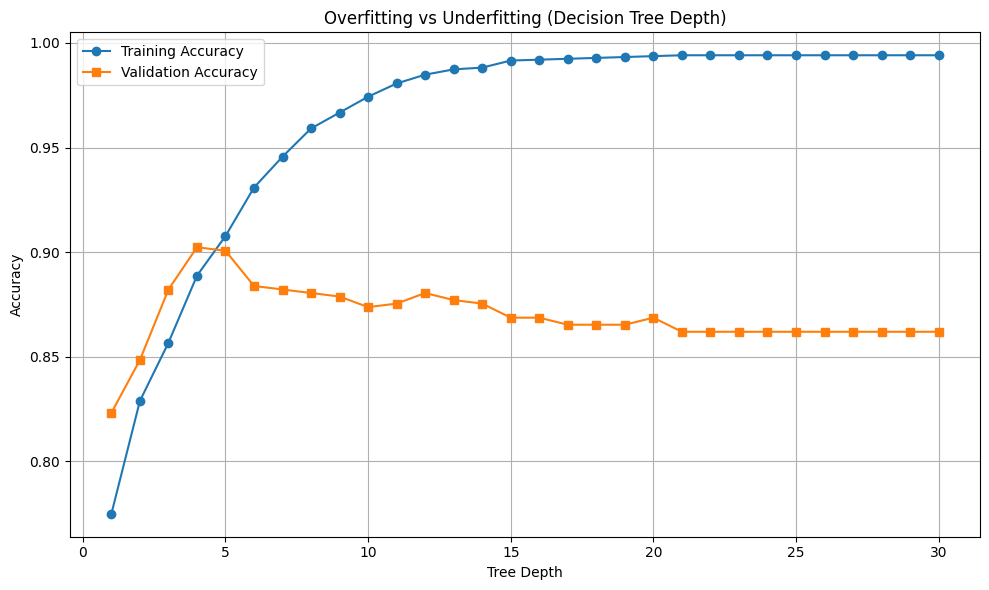


Best depth based on validation: 4


In [9]:
# Step 8: Validation curve - train and val accuracy vs max_depth
train_scores=[]
val_scores=[]
depth_range=range(1, 31)
for depth in depth_range:
    dt=DecisionTreeClassifier(max_depth=depth,random_state=42)
    dt.fit(X_train,y_train)
    train_scores.append(dt.score(X_train,y_train))
    val_scores.append(dt.score(X_test,y_test))

# Step 9: Plot training vs validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(depth_range,train_scores,label="Training Accuracy",marker='o')
plt.plot(depth_range,val_scores,label="Validation Accuracy",marker='s')
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Overfitting vs Underfitting (Decision Tree Depth)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# Step 10: Optimal Max Depth
optimal_depth=np.argmax(val_scores) +1
print(f"\nBest depth based on validation: {optimal_depth}")

In [10]:
# Step 11: Train Decision Tree Classifier of optimal max_depth
dt_model=DecisionTreeClassifier(random_state=42,max_depth=4)
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [11]:
# Step 12: Predict and evaluate
y_pred=dt_model.predict(X_test)

In [12]:
# Step 12: Predict and evaluate
y_pred=dt_model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
conf_matrix=confusion_matrix(y_test,y_pred)
class_report=classification_report(y_test, y_pred, target_names=le_target.classes_,zero_division=0)

print("Accuracy:",accuracy*100)
print("\nConfusion Matrix:\n",conf_matrix)
print("\nClassification Report:\n",class_report)

Accuracy: 90.23569023569024

Confusion Matrix:
 [[ 69   0  19   7   0]
 [  1   0   1   1   0]
 [ 22   0 340   3   0]
 [  2   0   1 127   0]
 [  0   0   0   1   0]]

Classification Report:
               precision    recall  f1-score   support

        7zip       0.73      0.73      0.73        95
      WinRar       0.00      0.00      0.00         3
       bzip2       0.94      0.93      0.94       365
        gzip       0.91      0.98      0.94       130
         zip       0.00      0.00      0.00         1

    accuracy                           0.90       594
   macro avg       0.52      0.53      0.52       594
weighted avg       0.90      0.90      0.90       594



In [13]:
import joblib

# Save everything as a dictionary
joblib.dump({'model': dt_model,'le_ext': le_ext,'le_target': le_target},'DecisionTree.joblib')

['DecisionTree.joblib']